In [12]:
import os, sys, glob

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.signal as signal

import mne

import tensorpac
import pactools

import nf_tools.preprocessing as nftprep

In [34]:
# Set subject ID
subj_id = 13
f_amp = [7, 15]
condition='maintenance'

if condition == 'encoding':
    condition_acr = 'e'
elif condition == 'maintenance':
    condition_acr = 'm'

subj_name = f'subj_{subj_id}'
print(os.listdir('../'))
outputs_path = '../outputs'
data_path = '../data'
meg_dir = os.path.join(data_path, f'subj_{subj_id}', 'meg')
mri_dir = os.path.join(data_path, f'subj_{subj_id}', 'mri')
fs_subjs_dir = os.path.join(data_path, 'fs_subjects_dir')

srcs_dir = os.path.join(outputs_path, subj_name, 'source_space')
os.makedirs(srcs_dir, exist_ok=True)
srcs_itc_dir = os.path.join(outputs_path, subj_name, 'source_space_itc')
os.makedirs(srcs_itc_dir, exist_ok=True)

srcs_pac_dir = os.path.join(outputs_path, subj_name, 'source_space_pac')
os.makedirs(srcs_pac_dir, exist_ok=True)

['.DS_Store', 'codes', 'data', 'plots_molly', 'outputs']


In [14]:

def mk_epochs_new(meg,  mod_freq=None, tmin=None, tmax=None, baseline=None, annot_pattern='', new_event_value=100):
    """This function creates epochs based on specified mod_freq and annotation_pattern
    Arguments:
        meg: annotated MNE object, where bad time spans are annotated as BAD_*
        tmin: start time of the epoch in seconds. This parameter should match with baseline.
        baseline: to specify baseline correction. e.g. tmin=0, baseline=(0, 0) applies no baseline correction.
        mod_freq: to specify the modulating frequency of interest. This parameter should match with the annot_pattern
        annot_pattern: The annotation pattern, based on which epochs are created.
        new_event_value: to specify new label for events. The default is 100. Optional argument.
    Returns:
        epoch: Epoch MNE object.
    Example1:
        The following call will create epochs from mod_freq=1 and encoding events, and will apply baseline correction
        between -0.5 and 0. The length of created epochs would be 8/mod_freq + abs(tmin) = 8 + 0.5 = 8.5 seconds or
        8.5 * sfreq = 8.5 * 300 samples
        mk_epochs(meg.copy(), mod_freq=1., tmin=-0.5, baseline=(-0.5, 0), annot_pattern='e/1.0/')
    Example2:
        create epochs from maintenance events with mod_freq=3.5
        mk_epochs(meg.copy(), mod_freq=3.5, tmin=0, baseline=(0, 0), annot_pattern='m/3.5/')
    Notes:
        tmin and annotation patterns should match.
        baseline = (None, 0) sets baseline to MNE defaults.
        baseline = (0, 0), tmin = 0 sets to no baseline.
        baseline = (-0.5, 0), tmin = -0.5
    """
    if not tmax:
        tmax = (8 / mod_freq) - 1 / meg.info['sfreq']
    events = mne.events_from_annotations(meg)
    annot = list(events[1].keys())
    indx_pattern = np.where([annot_pattern in k for k in annot])[0].tolist()
    event_vals_pattern = np.array(list(events[1].values()))[indx_pattern].tolist()
    indx_events = np.where(np.isin(events[0][:, 2], event_vals_pattern))[0].tolist()
    events4epoch = events[0][indx_events, :]
    events4epoch[:, 2] = new_event_value
    annot_epoch = mne.annotations_from_events(events4epoch, meg.info['sfreq'])
    meg.set_annotations(annot_epoch)
    epoch = mne.Epochs(meg, events=events4epoch, tmin=tmin, tmax=tmax, baseline=baseline)
    return epoch

In [15]:
# Load after-ICA MEG data and make epochs
meg = mne.io.read_raw_fif(os.path.join(meg_dir, 'after_ica_meg.fif'))


Opening raw data file ../data/subj_13/meg/after_ica_meg.fif...
    Read 5 compensation matrices
    Range : 0 ... 1579787 =      0.000 ...  5265.957 secs
Ready.
Opening raw data file /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/codes/../data/subj_13/meg/after_ica_meg-1.fif...
    Read 5 compensation matrices
    Range : 1579788 ... 2034107 =   5265.960 ...  6780.357 secs
Ready.
Current compensation grade : 3


Reading forward solution from /Users/keyvan.mahjoory/k1_analyses/prj_neuroflex/neuroflex_analysis/codes/../data/subj_13/mri/file-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8196 sources, 275 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
Processing fm= 1.0 Hz
Used Annotations descriptions: ['e/1.0/e0/t0/f/r0', 'e/1.0/e0/t0/f/r1', 'e/1.0/e0/t0/s/r0', 'e/1.0/e0/t0/s/r1', 'e/1.0/e0/tpi/f/r1', 'e/1.0/e0/tpi/s/r0', 'e/1.0/e0/tpi/s/r1', 'e/1.0/epi/t0/f/r1', 'e/1.0/epi/t0/s/r0', 'e/1.0/epi/t0/s/r1', 'e/1.0/epi/tpi/f/r1', 'e/1.0/epi/tpi/s/r0', 'e/1.0/epi/tpi/s/r1', 'e/1.5/e0/t0/f/r0', 'e/1.5/

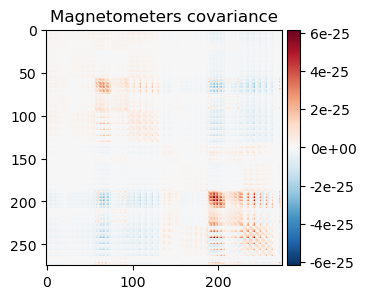

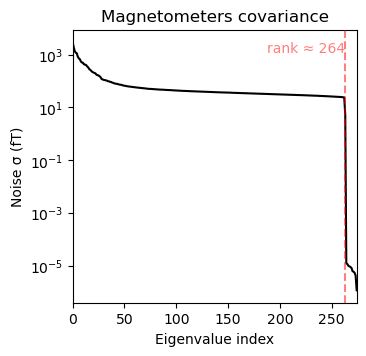

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5e-13 (2.2e-16 eps * 275 dim * 8.2  max singular value)
    Estimated rank (mag): 264
    MAG: rank 264 computed from 275 data channels with 0 projectors
    Setting small MAG eige

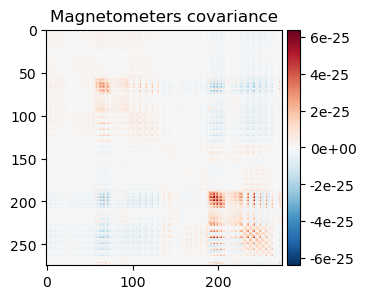

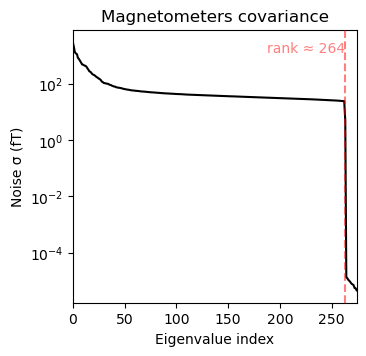

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.2e-13 (2.2e-16 eps * 275 dim * 8.5  max singular value)
    Estimated rank (mag): 264
    MAG: rank 264 computed from 275 data channels with 0 projectors
    Setting small MAG ei

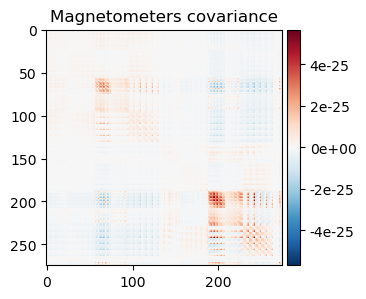

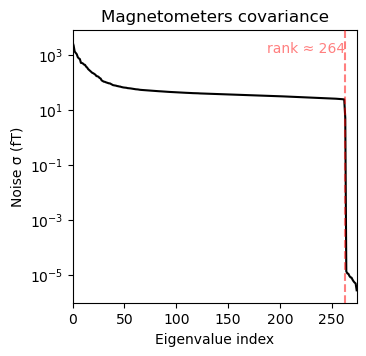

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.1e-13 (2.2e-16 eps * 275 dim * 8.4  max singular value)
    Estimated rank (mag): 264
    MAG: rank 264 computed from 275 data channels with 0 projectors
    Setting small MAG ei

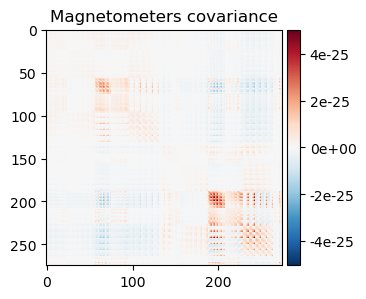

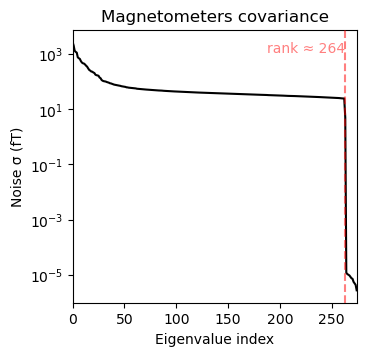

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.3e-13 (2.2e-16 eps * 275 dim * 8.7  max singular value)
    Estimated rank (mag): 264
    MAG: rank 264 computed from 275 data channels with 0 projectors
    Setting small MAG ei

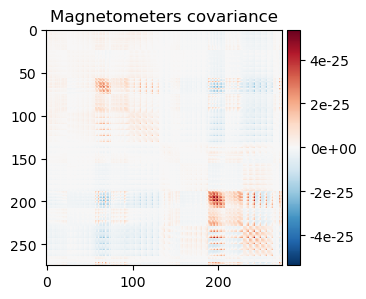

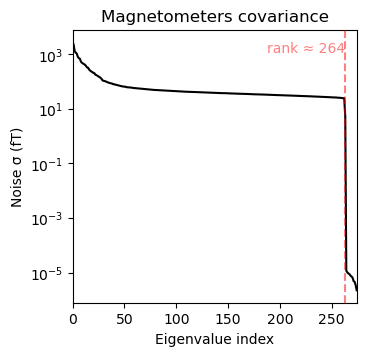

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 4.9e-13 (2.2e-16 eps * 275 dim * 8  max singular value)
    Estimated rank (mag): 264
    MAG: rank 264 computed from 275 data channels with 0 projectors
    Setting small MAG eige

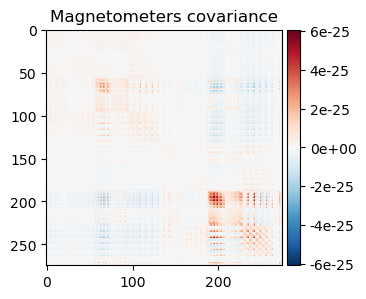

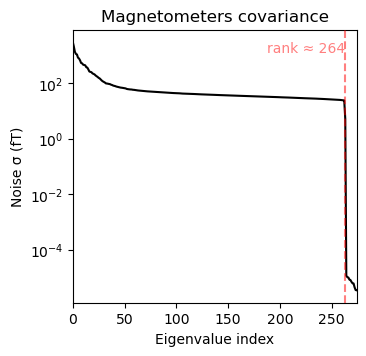

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.2e-13 (2.2e-16 eps * 275 dim * 8.5  max singular value)
    Estimated rank (mag): 264
    MAG: rank 264 computed from 275 data channels with 0 projectors
    Setting small MAG ei

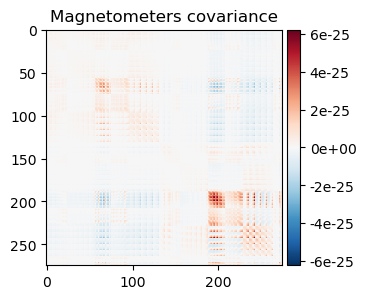

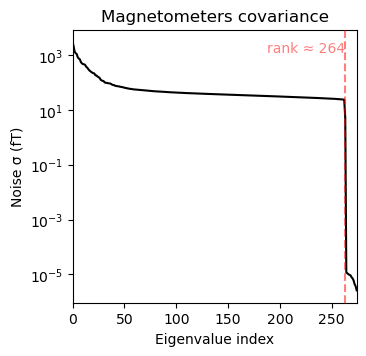

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 275 channels.
    275 out of 275 channels remain after picking
Removing 5 compensators from info because not all compensation channels were picked.
Selected 275 channels
Creating the depth weighting matrix...
    275 magnetometer or axial gradiometer channels
    limit = 8012/8196 = 10.022025
    scale = 7.9076e-11 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
Removing 5 compensators from info because not all compensation channels were picked.
Computing rank from covariance with rank=None
    Using tolerance 5.2e-13 (2.2e-16 eps * 275 dim * 8.6  max singular value)
    Estimated rank (mag): 264
    MAG: rank 264 computed from 275 data channels with 0 projectors
    Setting small MAG ei

In [16]:
stc_labels = []

# Load forward model
fwd = mne.read_forward_solution(os.path.join(mri_dir, 'file-fwd.fif'))

for j, fm in enumerate(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):

    print("======================================")
    print(f'Processing fm= {fm} Hz')
    print("======================================")

    # Estimate noine covariance matrices from all trials, tmin=-.2 tmax=-0.05 
    _epoch = mk_epochs_new(meg.copy(), mod_freq=float(fm), tmin=-0.2, baseline=None, 
                    annot_pattern=f'{condition_acr}/{fm}', new_event_value=101)
    noise_cov = mne.compute_covariance(_epoch, tmin=-0.2, tmax=-0.05,
                                    method='empirical')

    # Obtain separate Epochs for phase 0 and pi
    epoch = mk_epochs_new(meg.copy(), mod_freq=float(fm), tmin=0, baseline=None, 
                    annot_pattern=f'{condition_acr}/{fm}', new_event_value=101)
    

    # Estimate data covariance from aligned trials, tmin=0 tmax=8/fm
    data_cov = mne.compute_covariance(epoch, tmin=0.0, tmax=8/float(fm),
                                    method='empirical')

    # Visualize noise and data covariance matrices
    with mne.viz.use_browser_backend('matplotlib'):
        mne.viz.plot_cov(noise_cov, meg.info)

    # Source Reconstruction: MNE
    inv_operator = mne.minimum_norm.make_inverse_operator(epoch.info, fwd, data_cov,
                                                        loose=0.2, depth=0.8, verbose=True)
    method = "dSPM"
    snr = 3.
    lambda2 = 1. / snr ** 2
    stc = mne.minimum_norm.apply_inverse_epochs(epoch, inv_operator, lambda2, method=method, 
                            pick_ori='normal', verbose=False)

    # Read Atlas labels for subject
    labels = mne.read_labels_from_annot(subject=subj_name, parc='BN_Atlas', hemi='both', 
                                    surf_name='white', annot_fname=None, regexp=None, 
                                    subjects_dir=fs_subjs_dir, sort=True, verbose=False)
    # Create label to index dictionary
    label2index = {label.name: i for i, label in enumerate(labels)}

    # Time courses for all epochs and all labels (pca across dipoles)
    _stc_labels = np.array([k.extract_label_time_course(labels=labels, src=inv_operator['src'], mode='pca_flip', verbose=False) for k in stc])
    _stc_labels.shape # (num_epochs, num_labels, num_times)

    stc_labels.append(_stc_labels)




In [17]:

stg_l = ['A38m_L-lh', 'A41/42_L-lh', 'TE1.0/TE1.2_L-lh', 'A22c_L-lh',  'A22r_L-lh']    #'A38l_L-lh',
stg_r = ['A38m_R-rh', 'A41/42_R-rh', 'TE1.0/TE1.2_R-rh', 'A22c_R-rh', 'A22r_R-rh'] # , 'A38l_R-rh'

len(stc_labels), stc_labels[0].shape

(7, (72, 212, 2400))

In [18]:
seed_r = 'A22r_R-rh'
indx_seed_r = label2index[seed_r]
stc_seedr_fms = [k[:, indx_seed_r, :] for k in stc_labels]


In [19]:
stc_labels[0].shape


(72, 212, 2400)

In [36]:

srcs_pac_dir = os.path.join(outputs_path, subj_name, 'source_space_pac', f'famp_{f_amp[0]}_{f_amp[1]}_{condition}')
os.makedirs(srcs_pac_dir, exist_ok=True)

for j, fm in enumerate(['2.0']):#(['1.0', '1.5', '2.0', '2.5', '3.0', '3.5', '4.0']):
    fm_value = float(fm)
    p = tensorpac.Pac(f_pha=[fm_value-.25, fm_value, fm_value+.25], f_amp=f_amp, dcomplex='wavelet')
    stc_seedr = stc_seedr_fms[j]
    phtcs_sr = p.filter(meg.info['sfreq'], stc_seedr, ftype='phase', n_jobs=1)
    amplitudes = np.stack([p.filter(meg.info['sfreq'], stc_labels[j][:, i, :], ftype='amplitude', n_jobs=1) for i in range(stc_labels[j].shape[1])], axis=1).squeeze()
    print(phtcs_sr.shape, phtcs_sr.shape,  amplitudes.shape)

    p.idpac = (1, 0, 4) #(1, 1, 3)
    pac = p.fit(phtcs_sr, amplitudes)
    pac.shape

    pac_mean = pac.mean((-2, -1))
    pac_mean.shape

    pac_mean_hr = mne.labels_to_stc(labels, pac_mean, tmin=0, tstep=1, subject=subj_name, src=None, verbose=None)

    # Plot PAC right
    brain_kwargs = dict(alpha=1, background='white', cortex='low_contrast', silhouette=True)
    brain = mne.viz.Brain(subj_name, hemi='both', surf='inflated', subjects_dir=fs_subjs_dir, **brain_kwargs)
    #kwargs = dict(fmin=pac_mean_hr.data.min(), fmax=pac_mean_hr.data.max(), alpha=0.7, 
    #            smoothing_steps=7)
    kwargs = dict(fmin=1.46, fmax=3.96, alpha=0.7, 
                smoothing_steps=7)
    brain.add_data(pac_mean_hr.lh_data, hemi='lh', vertices=pac_mean_hr.lh_vertno, **kwargs)
    brain.add_data(pac_mean_hr.rh_data, hemi='rh', vertices=pac_mean_hr.rh_vertno, **kwargs)
    brain.show_view(azimuth=0, distance=700)
    brain.add_text(0.1, 0.9, f'fm = {fm}     f_amp = {f_amp[0]} - {f_amp[1]}', 'title', font_size=16, color=(0, 0, 0))
    brain.save_image(filename=os.path.join(srcs_pac_dir, f'pac_{fm}_{subj_name}_right.png'), mode='rgb')


    # Plot PAC left
    brain_kwargs = dict(alpha=1, background='white', cortex='low_contrast', silhouette=True)
    brain = mne.viz.Brain(subj_name, hemi='both', surf='inflated', subjects_dir=fs_subjs_dir, **brain_kwargs)
    #kwargs = dict(fmin=pac_mean_hr.data.min(), fmax=pac_mean_hr.data.max(), alpha=0.7, 
    #            smoothing_steps=7)
    kwargs = dict(fmin=1.46, fmax=3.96, alpha=0.7, 
            smoothing_steps=7)
    brain.add_data(pac_mean_hr.lh_data, hemi='lh', vertices=pac_mean_hr.lh_vertno, **kwargs)
    brain.add_data(pac_mean_hr.rh_data, hemi='rh', vertices=pac_mean_hr.rh_vertno, **kwargs)
    brain.show_view(azimuth=180, distance=700)
    brain.add_text(0.1, 0.9, f'fm = {fm}     f_amp = {f_amp[0]} - {f_amp[1]}', 'title', font_size=16, color=(0, 0, 0))
    brain.save_image(filename=os.path.join(srcs_pac_dir, f'pac_{fm}_{subj_name}_left.png'), mode='rgb')


Phase Amplitude Coupling object defined
WARNING | If you want to normalize the estimated PAC, you should select a surrogate method (second digit of `idpac`). Normalization ignored.
    true PAC estimation using Mean Vector Length (MVL, Canolty et al. 2006)


(2, 72, 2400) (2, 72, 2400) (212, 72, 2400)
